### Gaussian Bandits
This notebook experiments with Gaussian multi-armed bandits and different action selection functions:
- Random
- epsilon-greedy
- epsillon-decay-greedy
- Upper Confidence Bound (UCB)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class definitions
#
class Bandit:
    """
    Bandit class
    """
    def __init__(self, name, arms, solver='egreedy'):
        self.name = name # pseudo-name
        self.t = 0 # time (in steps)
        self.K = len(arms) # number of arms
        self.solver = solver
        self.arms = arms # arms
        self.counts = np.zeros(self.K, dtype=int) # pulls per arm
        self.rewards = {i: [] for i in range(self.K)} # rewards per arm
        self.policy = np.array([]) # sequence of played arms
        self.policy_payoff = np.array([]) # policy payoff

    def select_arm(self):
        """ Select the arm to pull next """
        # increase time step
        self.t += 1
        # warmstart: play every arm at least once
        is_zero = np.where(self.counts == 0)[0]
        if len(is_zero) > 0:
            est = {i: 0.0 for i in range(self.K)}
            for j in is_zero:
                est[j] = 1.0
        # suggestion based on solver
        else:
            if self.solver == 'random':
                est = random_(self.K)
            elif self.solver == 'egreedy':
                est = egreedy(self.K, self.t, self.rewards)
            elif self.solver == 'edecaygreedy':
                est = egreedy(self.K, self.t, self.rewards, decay=True)
            elif self.solver == 'ucb':
                est = ucb(self.K, self.t, self.counts, self.rewards)
            else:
                raise Exception('Invalid solver name')
        # final decision
        i = max(est, key=est.get)
        self.policy = np.append(self.policy, i)
        return i

    def pull_arm(self, arm_index):
        """ Pull the selected arm """
        r = self.arms[arm_index].pull()
        self.rewards[arm_index].append(r)
        self.counts[arm_index] += 1
        self.policy_payoff = np.append(self.policy_payoff, r)

    def get_best_arm(self):
        """ Get the arm with the highest average reward """
        mean_r = {i: np.mean(r) for i, r in self.rewards.items()}
        best_arm_index = max(mean_r, key=mean_r.get)
        return self.arms[best_arm_index]

    def get_policy_payoff(self):
        """ Compute the average reward for the chosen policy """
        return np.mean(self.policy_payoff)
#
class GaussianArm:
    """ 
    Gaussian Arm class
    """
    def __init__(self, name, mu, sig):
        self.name = name # pseudo-name
        self.mu = mu # mean 
        self.sig = sig # standard deviation

    def pull(self):
        r = np.random.normal(self.mu, self.sig)
        return r

In [3]:
# Action selection functions
#
def random_(K):
    """
    K: number of arms
    """
    est = {i: random.random() for i in range(K)}
    return est

def egreedy(K, t, R, epsilon=0.1, decay=False):
    """
    K: number of arms
    t: current timestep
    R: sequence of past rewards
    epsilon: the epsilon constant
    decay: decreasing epsilon over time
    """
    if decay:
        epsilon = 1.0 / np.log(t + 0.00001)
    if np.random.uniform(0.0, 1.0) > epsilon:
        est = {i: np.mean(r) for i, r in R.items()} # exploitation
    else:
        est = {i: np.random.uniform(0.0, 1.0) for i in range(K)} # exploration
    return est

def ucb(K, t, counts, R):
    """
    K = the number of arms (domains)
    t = current timestep
    counts = the total number of trials
    R = the sequence of past rewards
    """
    est = {}
    for i, r in R.items():
        n_i = counts[i]
        mu_i = np.mean(r)
        bound = np.sqrt((2 * np.log(t)) / n_i) # At = Qt(A) + c*sqrt(lnt/Nt(a))
        est[i] = mu_i + bound
    return est

In [4]:
# Define gaussian arms
arms = [
    GaussianArm(name='a1', mu=10.0, sig=5.0),
    GaussianArm(name='a2', mu=12.0, sig=4.0),
    GaussianArm(name='a3', mu=15.0, sig=4.0),
    GaussianArm(name='a4', mu=17.0, sig=3.0),
    GaussianArm(name='a5', mu=20.0, sig=5.0),
    # add more arms
]

# Define bandit
b1 = Bandit('Random', arms, 'random') # random solver
b2 = Bandit('Epsilon-greedy', arms, 'egreedy') # epsilon-greedy solver
b3 = Bandit('Epsilon-decay-greedy', arms, 'edecaygreedy') # epsilon-decay-greedy solver
b4 = Bandit('UCB', arms, 'ucb') # UCB solver

# Define budget (in steps)
budget = 1000

# Play
for b in [b1, b2, b3, b4]:
    while b.t <= budget:
        # select arm
        arm_index = b.select_arm()
        # pull arm
        b.pull_arm(arm_index)
    # Print results
    print(b.name)
    print('\tBest arm:', b.get_best_arm().name)
    print('\tAverage payoff:', b.get_policy_payoff())

Random
	Best arm: a5
	Average payoff: 14.49848156281739
Epsilon-greedy
	Best arm: a5
	Average payoff: 19.75044807639787
Epsilon-decay-greedy
	Best arm: a5
	Average payoff: 19.297890170603168
UCB
	Best arm: a5
	Average payoff: 20.090854653207277


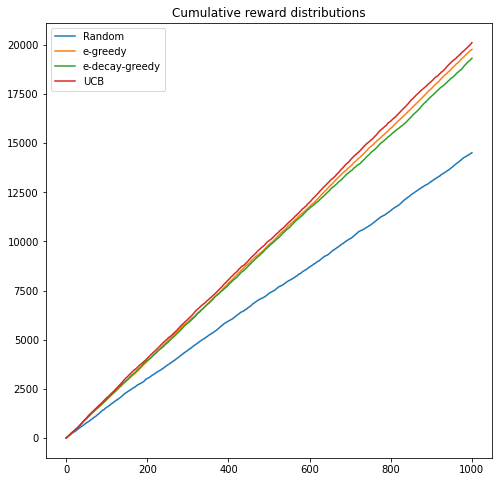

In [5]:
# Results
#
# Cumulative reward distributions
cdf1 = np.cumsum(b1.policy_payoff)
cdf2 = np.cumsum(b2.policy_payoff)
cdf3 = np.cumsum(b3.policy_payoff)
cdf4 = np.cumsum(b4.policy_payoff)
# plot CDFs
plt.figure(figsize=(8, 8))
plt.plot(cdf1, label="Random")
plt.plot(cdf2, label="e-greedy")
plt.plot(cdf3, label="e-decay-greedy")
plt.plot(cdf4, label="UCB")
plt.title('Cumulative reward distributions')
plt.legend()